In [51]:
import polars as pl 
import polars.selectors as cs 
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from yahoo_fin.stock_info import get_data
import phoenix as px 
import umap
from sklearn.linear_model import LinearRegression
import utils
from dateutil.relativedelta import relativedelta 
import numpy as np
import seaborn.objects as so 
import matplotlib.pyplot as plt

to test against MSCI: recuced with umap (2,3,?), and PCA

test against pct_change and raw data

## Getting data

In [2]:
sentences = pl.read_parquet(r"C:\Users\faune\Desktop\thesis\daily_headlines.parquet")
msci_world = get_data(ticker="^990100-USD-STRD", start_date="2008-01-01", end_date="2016-01-01")
msci_close = pl.DataFrame(msci_world[['close']].dropna().pct_change().reset_index())
to_join = msci_close.drop_nulls().with_columns(pl.col('index').cast(pl.Date)).rename({'index': 'date'})
sentences = sentences.with_columns(pl.col('date').cast(pl.Date))
frame = sentences.join(to_join, on='date').with_columns(pl.col('date').dt.quarter().alias('quarter'), pl.col('date').dt.year().alias('year'))
reducer = umap.UMAP()
reduced = reducer.fit_transform(frame.select('embeddings').to_series().to_list())

In [39]:
frame = frame.with_columns(pl.Series(name = 'reduced', values = reduced))
# sns.scatterplot(data = frame.with_columns(pl.col('reduced').list.to_struct()).unnest('reduced').rename({'field_0':'x', 'field_1':'y'}).select('x','y', 'label').to_pandas(), x= 'x', y = 'y', hue='label', palette = sns.cubehelix_palette(n_colors=3))

## Getting lineplots

In [57]:
frame

date,label,sentence,embeddings,close,quarter,year,reduced
date,i64,str,list[f64],f64,i8,i32,list[f32]
2008-08-08,0,"""Arrested Bissa…","[-0.033539, 0.04306, … 0.019379]",0.004141,3,2008,"[11.726994, 3.51857]"
2008-08-11,1,"""New York Senat…","[-0.034912, 0.019608, … 0.00705]",0.008764,3,2008,"[11.735765, 3.533101]"
2008-08-12,0,"""Gold plunges t…","[-0.044525, 0.028824, … -0.011269]",-0.009199,3,2008,"[11.835114, 3.430492]"
2008-08-13,0,"""DreamWorks Ani…","[-0.032074, 0.025146, … 0.015137]",-0.011348,3,2008,"[11.761068, 3.518541]"
2008-08-14,1,"""Temecula Valle…","[-0.043121, 0.02681, … 0.010452]",0.004099,3,2008,"[11.697535, 3.583787]"
…,…,…,…,…,…,…,…
2015-12-04,1,"""Sprott Focus T…","[-0.014244, 0.033936, … -0.007206]",0.009892,4,2015,"[4.076247, 0.455556]"
2015-12-07,0,"""Rentrak Announ…","[0.006672, 0.037231, … 0.026917]",-0.004838,4,2015,"[3.879737, 1.601451]"
2015-12-08,0,"""ATWOOD OCEANIC…","[-0.003252, 0.035645, … 0.014435]",-0.009427,4,2015,"[4.233662, 0.279806]"


In [ ]:
def get_linear_regression(x_col: str, y_col: str, df: pl.DataFrame):
    model = LinearRegression()
    X = df.select(pl.col('embeddings')).to_series().to_list()
    y = df.select(pl.col('close')).to_series().to_list()
    
    ind = -int(len(X)/3)

    reg = model.fit(X[:ind], y [:ind])

    out_of_sample = np.dot(a=reg.coef_, b=np.transpose(X[ind:]))
    predicted = np.append(reg.predict(X[:ind]), out_of_sample)

    with_predicted = df.with_columns(pl.Series(name = "predictions", values = predicted))
    with_predicted = with_predicted.select('date', 'close', 'predictions') 

    sns.set_theme(context='notebook', rc={'figure.figsize':(20,5)}, palette=sns.cubehelix_palette(2), style='white')
    sns.lineplot(data = with_predicted.to_pandas().set_index('date'))
    plt.axvline(with_predicted.select('date')[ind].to_series().to_list()[0], 0,1, color = 'blue')
    plt.text(x=with_predicted.select('date')[ind].to_series().to_list()[0] + relativedelta(years=1), y = 0.075, s = "Out of Sample")

    return

In [63]:
model = LinearRegression()
X = frame.select(pl.col('embeddings')).to_series().to_list()
y = frame.select(pl.col('close')).to_series().to_list()
test = model.fit(X, y)

In [64]:
test.score(X,y)

0.6472944335875574

In [110]:

out_of_sample = np.dot(a=test.coef_, b=np.transpose(X[-int(len(X)/3):]))

In [106]:
predicted = np.append(test.predict(X[:-int(len(X)/3)]), out_of_sample)
with_predicted = frame.with_columns(pl.Series(name = "predictions", values = predicted))

In [107]:
with_predicted = with_predicted.select('date', 'close', 'predictions') 

In [130]:
len(X[-int(len(X)/3):])

1719

In [137]:
with_predicted.select('date')[-int(len(X)/3)].to_series().to_list()[0]

datetime.date(2013, 6, 25)

In [126]:
with_predicted.select(pl.col('predictions'))

573

In [131]:
with_predicted.with_row_index().filter(pl.col('index').eq(int(len(X)/3))).select('index').to_series().to_list()[0]

index,date,close,predictions
u32,date,f64,f64
573,2011-01-18,0.005042,0.000271


In [ ]:
relativedelta(years=1)

In [144]:
with_predicted.select('date')[-int(len(X)/3)].to_series().to_list()[0] + relativedelta(years=1)

datetime.date(2014, 6, 25)

Text(2014-06-25, 0.075, 'Out of Sample')

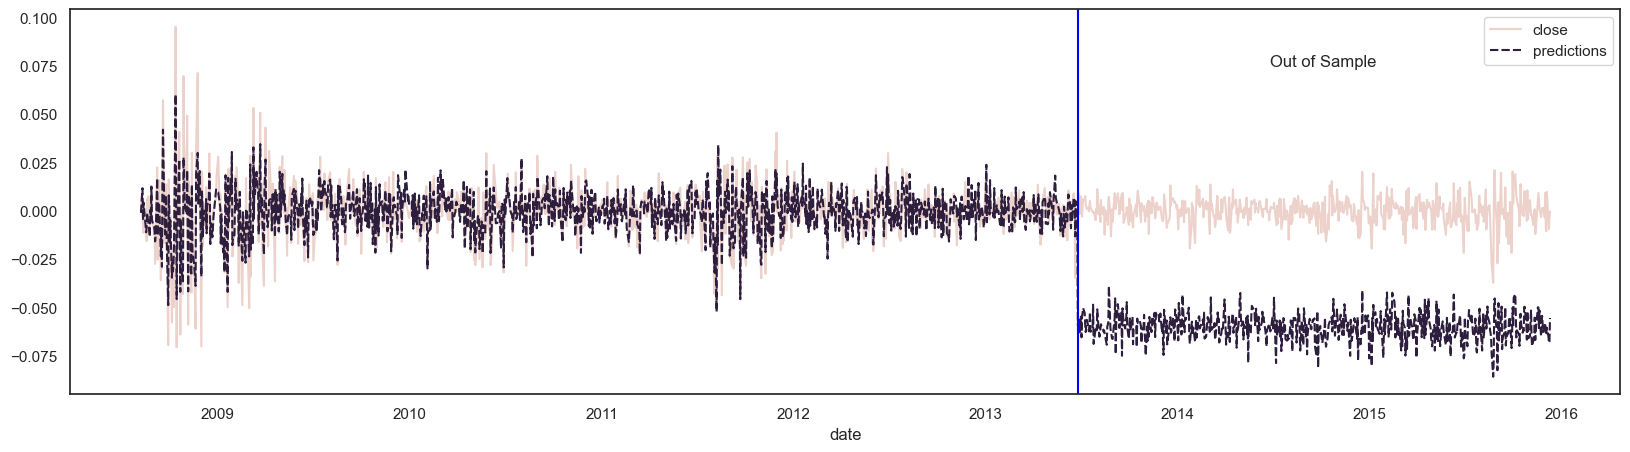

In [145]:
from datetime import date
sns.set_theme(context='notebook', rc={'figure.figsize':(20,5)}, palette=sns.cubehelix_palette(2), style='white')
sns.lineplot(data = with_predicted.to_pandas().set_index('date'))
plt.axvline(with_predicted.select('date')[-int(len(X)/3)].to_series().to_list()[0], 0,1, color = 'blue')
plt.text(x=with_predicted.select('date')[-int(len(X)/3)].to_series().to_list()[0] + relativedelta(years=1), y = 0.075, s = "Out of Sample")

In [89]:
msci_world

,open,high,low,close,adjclose,volume,ticker
2008-01-02,1578.300049,1578.400024,1578.000000,1578.300049,1578.300049,0.0,^990100-USD-STRD
2008-01-03,1578.300049,1582.300049,1573.400024,1577.500000,1577.500000,0.0,^990100-USD-STRD
2008-01-04,1571.699951,1573.000000,1541.599976,1541.699951,1541.699951,0.0,^990100-USD-STRD
2008-01-06,NaN,NaN,NaN,NaN,NaN,NaN,^990100-USD-STRD
2008-01-07,1535.199951,1535.300049,1535.000000,1535.099976,1535.099976,0.0,^990100-USD-STRD
...,...,...,...,...,...,...,...
2015-12-27,NaN,NaN,NaN,NaN,NaN,NaN,^990100-USD-STRD
2015-12-28,1674.000000,1674.699951,1664.300049,1670.400024,1670.400024,0.0,^990100-USD-STRD
2015-12-29,1670.000000,1688.300049,1669.900024,1685.599976,1685.599976,0.0,^990100-USD-STRD
2015-12-30,1686.199951,1688.000000,1676.400024,1676.400024,1676.400024,0.0,^990100-USD-STRD
